In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
# Set to LateX
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}"
})

In [2]:
# Prepare to read multiple result files
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = 'AdvDiff2D'
subdirs = [('EPSvsNt1', 100), ('EPSvsNt2', 200)]


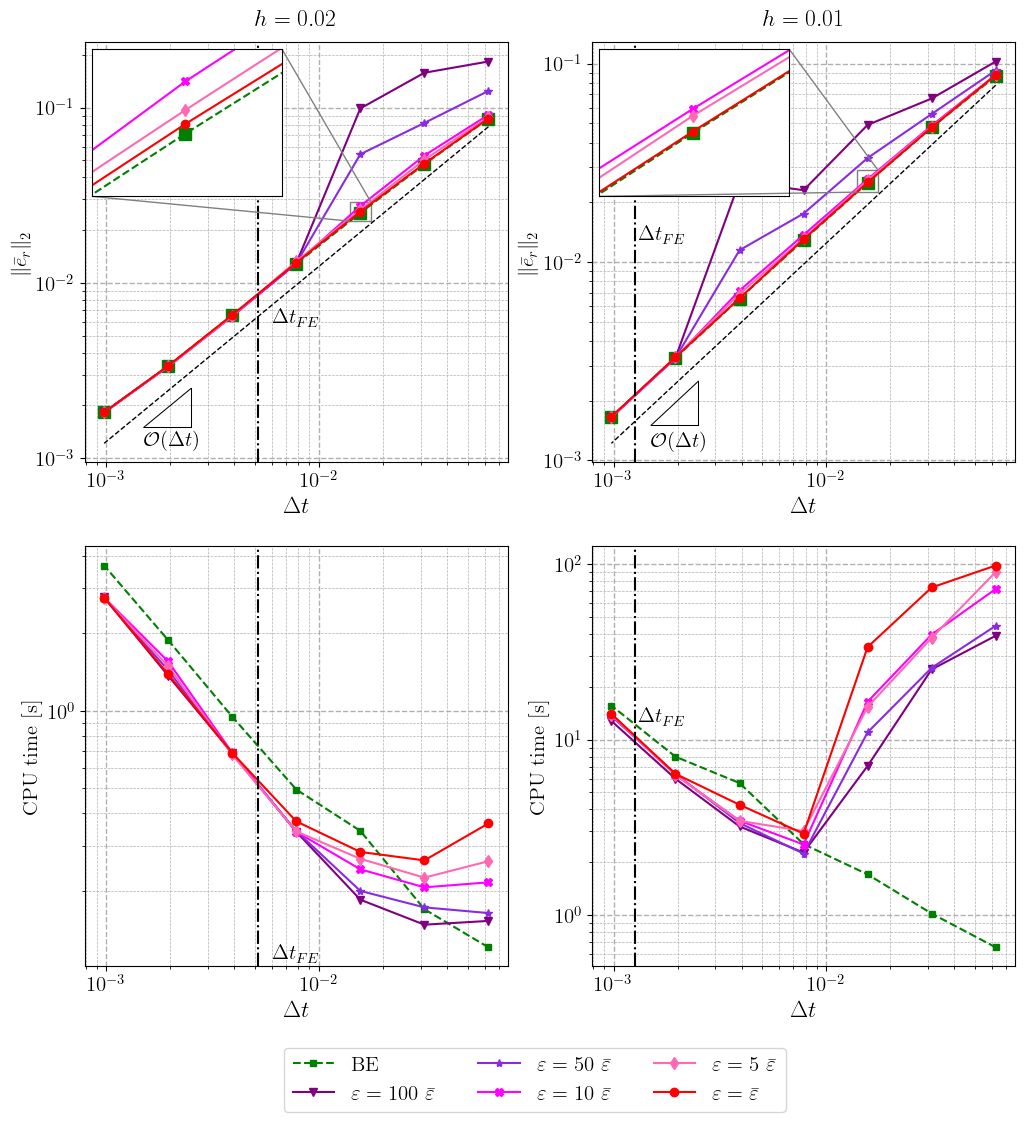

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Predefined styling (long enough to cover any nIMEX)
all_markers = ['v', '*', 'X', 'd', 'o', 'p', 's', 'h']
all_colors = ['purple', 'blueviolet', 'magenta', 'hotpink', 'red', 'maroon', 'teal', 'orange']
all_labels = [
    r"$\varepsilon = 100 \ \bar{\varepsilon}$",
    r"$\varepsilon = 50 \ \bar{\varepsilon}$",
    r"$\varepsilon = 10 \ \bar{\varepsilon}$",
    r"$\varepsilon = 5 \ \bar{\varepsilon}$",
    r"$\varepsilon = \bar{\varepsilon}$",
    r"$\varepsilon = 0.1 \ \bar{\varepsilon}$",
    r"$\varepsilon = 0.01 \ \bar{\varepsilon}$",
    r"$\varepsilon = 0.001 \ \bar{\varepsilon}$"
]

xdeltaFE = [6e-3, 1.3e-3]
ydeltaFE = [0.025, 0.1]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for col, (subdir, Nh) in enumerate(subdirs):
    # Column title: h = 2/Nh
    pos = axs[0, col].get_position()
    x = pos.x0 + pos.width / 2
    y = pos.y1 + 0.01
    fig.text(
        x, y,
        rf"$h = {2/Nh:.2f}$",
        ha="center", va="bottom", fontsize=17
    )

    path = os.path.join(base_dir, os.pardir, os.pardir,
                        '__RESULTS', problem_name, subdir)
    results = np.load(os.path.join(path, "results.npz"), allow_pickle=True)
    Nt_FE = results['Nt_FE'].item()
    Nts = results['Nt_values']
    errBE = results['errors_l2'].item()['BE']
    errIMEX = results['errors_l2'].item()['IMEX-RB']
    timesBE = results['times'].item()['BE']
    timesIMEX = results['times'].item()['IMEX-RB']
    subiters = results['subiters'].item()['IMEX-RB']

    # Build mask for subiters
    mask = np.zeros_like(subiters, dtype=bool)
    for i, _Nt in enumerate(Nts):
        mask[i, :, :_Nt] = True
    masked_subiters = np.ma.masked_array(subiters, mask=~mask)

    nIMEX = errIMEX.shape[1] - 2  # number of epsilon cases in this file

    # top subplot: relative error convergence) with inset
    ax_err = axs[0, col]
    ax_err.loglog(1 / Nts, errBE, 's', linestyle='--',
                  markersize=8, color='green', label='BE')
    for idx in range(nIMEX):
        m = all_markers[idx]
        c = all_colors[idx]
        lbl = all_labels[idx]
        ax_err.loglog(
            1 / Nts,
            errIMEX[:, idx],
            f'-{m}',
            markersize=6,
            color=c,
            label=lbl
        )

    # reference slope line
    ax_err.loglog(
        1 / Nts,
        (Nts[0] * errBE[0] * 0.9) / Nts,
        color='k',
        linestyle='--',
        linewidth=1
    )

    # slope triangle
    x0, y0 = 0.0015, 0.0015
    dx = 0.001
    dy = dx
    ax_err.plot([x0, x0 + dx], [y0, y0], 'k-', linewidth=0.75)
    ax_err.plot([x0 + dx, x0 + dx], [y0, y0 + dy], 'k-', linewidth=0.75)
    ax_err.plot([x0 + dx, x0], [y0 + dy, y0], 'k-', linewidth=0.75)
    ax_err.text(
        x0, y0 - dy / 2.5,
        r"$\mathcal{O}(\Delta t)$",
        fontsize=15, ha='left', va='bottom'
    )

    ax_err.axvline(1 / Nt_FE, color='k', linestyle='-.')
    ax_err.text(
        xdeltaFE[col],
        ax_err.get_ylim()[1] * ydeltaFE[col],
        r"$\Delta t_{FE}$",
        fontsize=15,
        color='k'
    )

    # Inset axis
    axins = inset_axes(ax_err, width="45%", height="35%", loc='upper left')
    axins.loglog(1 / Nts, errBE, 's', markersize=8,
                 linestyle="--", color='green')
    for idx in range(nIMEX):
        m = all_markers[idx]
        c = all_colors[idx]
        axins.loglog(
            1 / Nts,
            errIMEX[:, idx],
            f'-{m}',
            markersize=6,
            color=c
        )
    axins.set_xlim(1.4e-2, 1.75e-2)
    axins.set_ylim(2.25e-2, 2.9e-2)
    axins.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
    mark_inset(ax_err, axins, loc1=1, loc2=3, fc="none", ec="0.5")

    ax_err.grid(which='major', linewidth=1, linestyle='--')
    ax_err.grid(which='minor', linewidth=0.5, linestyle='--')
    ax_err.tick_params(axis='both', which='major', labelsize=15)
    ax_err.set_xlabel(r"$\Delta t$", fontsize=17)
    ax_err.set_ylabel(r"$\|\bar{e}_r\|_2$", fontsize=15)

    # Bottom subplot: CPU time
    ax_time = axs[1, col]
    ax_time.loglog(
        1 / Nts,
        timesBE,
        '--s',
        markersize=4,
        color='green',
        label='BE'
    )
    for idx in range(nIMEX):
        m = all_markers[idx]
        c = all_colors[idx]
        lbl = all_labels[idx]
        ax_time.loglog(
            1 / Nts,
            timesIMEX[:, idx],
            f'-{m}',
            markersize=6,
            color=c,
            label=lbl
        )

    ax_time.axvline(1 / Nt_FE, color='k', linestyle='-.')
    ax_time.text(
        xdeltaFE[col],
        ax_time.get_ylim()[1] * ydeltaFE[col],
        r"$\Delta t_{FE}$",
        fontsize=15,
        color='k'
    )

    ax_time.tick_params(axis='both', which='major', labelsize=15)
    ax_time.grid(which='major', linestyle='--', linewidth=1)
    ax_time.grid(which='minor', linestyle='--', linewidth=0.5)
    ax_time.set_xlabel(r"$\Delta t$", fontsize=17)
    ax_time.set_ylabel("CPU time [s]", fontsize=15)

# Single external legend (errors + times)
handles, labels = axs[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    fontsize=15,
    ncol=3
)

plt.savefig(
    f'plots/combined_eps_Nh_{subdirs[0][1]}_{subdirs[1][1]}.pdf',
    bbox_inches="tight"
)


## Study average iterations and iterations over time varying $\varepsilon$
for $N_h = 100$

In [4]:
# Read now a single result file, to plot iterations over time
Nh = 100
problem_name = 'AdvDiff2D'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
path = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name, 'EPSvsNt1')
# path = "/home/riccardo/Desktop/PhD/MyRepos/FD-PyIMEX-RB/__RESULTS/AdvDiff2D/EPSvsNt1"
results = np.load(os.path.join(path, "results.npz"), allow_pickle=True)
Nt_FE = results['Nt_FE'].item()
Nts = results['Nt_values']
errBE = results['errors_l2'].item()['BE']
errIMEX = results['errors_l2'].item()['IMEX-RB']
timesBE = results['times'].item()['BE']
timesIMEX = results['times'].item()['IMEX-RB']
subiters = results['subiters'].item()['IMEX-RB']
mask = np.zeros_like(subiters, dtype=bool)
for i, _Nt in enumerate(Nts):
    mask[i, :, :_Nt] = True
masked_subiters = np.ma.masked_array(subiters, mask=~mask)

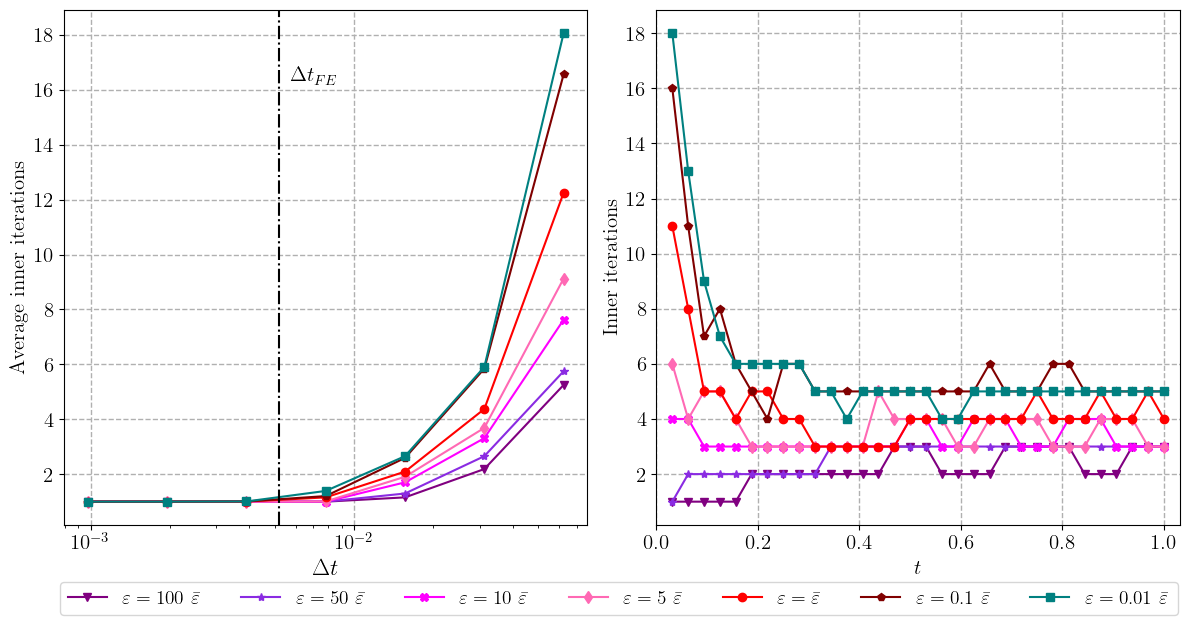

In [5]:
# Determine how many epsilon cases are available
num_eps = masked_subiters.shape[1]
indices = list(range(num_eps))

markers = all_markers[:num_eps]
colors = all_colors[:num_eps]
labels = all_labels[:num_eps]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: average inner iterations vs Δt
ax = axs[0]
for idx, m, c, lbl in zip(indices, markers, colors, labels):
    mean_iter = np.mean(masked_subiters[:, idx] + 1, axis=-1)
    ax.semilogx(
        1 / Nts,
        mean_iter,
        f'-{m}',
        markersize=6,
        color=c,
        label=lbl
    )
ax.axvline(1 / Nt_FE, color='k', linestyle='-.')
ax.text(5.7e-3, 16.3, r"$\Delta t_{FE}$", fontsize=15, color='k')
ax.grid(which='major', linestyle='--', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r"$\Delta t$", fontsize=17)
ax.set_ylabel("Average inner iterations", fontsize=15)

# Right subplot: inner iterations vs time for Nt_idx = 1
ax = axs[1]
Nt_idx = 1
tvec = np.linspace(0, 1, Nts[Nt_idx] + 1)[1:]
for idx, m, c, lbl in zip(indices, markers, colors, labels):
    ax.plot(
        tvec,
        subiters[Nt_idx, idx, :Nts[Nt_idx]] + 1,
        f'-{m}',
        markersize=6,
        color=c,
        label=lbl
    )
ax.grid(which='major', linestyle='--', linewidth=1)
ax.set_xlim([0, 1 + 1 / Nts[Nt_idx]])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel("Inner iterations", fontsize=15)

# Single external legend on the right, one column
handles, legend_labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.52, -0.05),
    fontsize=14,
    ncol=7
)

plt.tight_layout()
plt.savefig(f'plots/subiters_eps_combined_Nh_{Nh}.pdf', bbox_inches="tight")
